In [10]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("../Q1_clean.csv")
data = df.fillna(0)
data.head()

,Price,Review Scores Rating,Neighbourhood,Property Type,Room Type
0,549,96.0,Manhattan,Apartment,Private room
1,149,100.0,Brooklyn,Apartment,Entire home/apt
2,250,100.0,Manhattan,Apartment,Entire home/apt
3,90,94.0,Brooklyn,Apartment,Private room
4,270,90.0,Manhattan,Apartment,Entire home/apt


# EDA

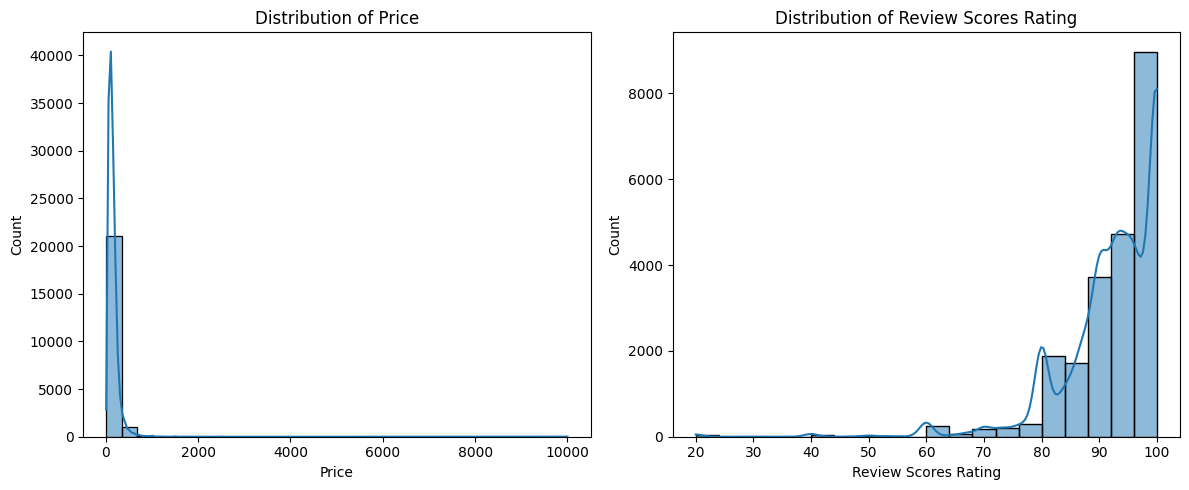

In [12]:
df.columns = df.columns.str.strip()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Distribution of Price")

plt.subplot(1, 2, 2)
sns.histplot(df['Review Scores Rating'], bins=20, kde=True)
plt.title("Distribution of Review Scores Rating")
plt.tight_layout()
plt.show()

# Transform categorical variables 

In [13]:
#avg = data.groupby('Neighbourhood')[['Price', 'Review Scores Rating']].mean()

data.columns = data.columns.str.strip()
categorical_cols = ['Neighbourhood', 'Review Scores Rating', 'Property Type']
dummy = pd.get_dummies(data[categorical_cols], drop_first=True)
encode = pd.concat([data, dummy], axis = 1)
y = encode['Price']
X = dummy


# Train Test Split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dummy, y, test_size = 0.2,random_state=5)

#help visualize stuff
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (17722, 22)
X_test shape: (4431, 22)
y_train shape: (17722,)
y_test shape: (4431,)


# Model building + performance comparsion

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

models = {
    'Neighbourhood Only': pd.get_dummies(data['Neighbourhood'], drop_first=True),
    'Property Type Only': pd.get_dummies(data['Property Type'], drop_first=True),
    'Room Type Only' : pd.get_dummies(data["Room Type"], drop_first=True),
    'Review Scores Rating Only': data[['Review Scores Rating']],
    'All Combined': pd.get_dummies(data[['Neighbourhood', 'Property Type', 'Room Type', 'Review Scores Rating']], drop_first=True)
}

results = []

for model_name, features in models.items():

    # redo train test split
    X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=5)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': model_name,
        'Train RMSE': round(train_rmse, 2),
        'Test RMSE': round(test_rmse, 2),
        'Train R^2': round(train_r2, 3),
        'Test R^2': round(test_r2, 3)
    })

results_df = pd.DataFrame(results)
print(results_df)

                       Model  Train RMSE  Test RMSE  Train R^2  Test R^2
0         Neighbourhood Only      150.01     125.01      0.043     0.065
1         Property Type Only      152.93     128.84      0.005     0.007
2             Room Type Only      142.02     116.36      0.142     0.190
3  Review Scores Rating Only      153.10     128.86      0.003     0.007
4               All Combined      139.05     112.65      0.178     0.241


# Correlation Plots

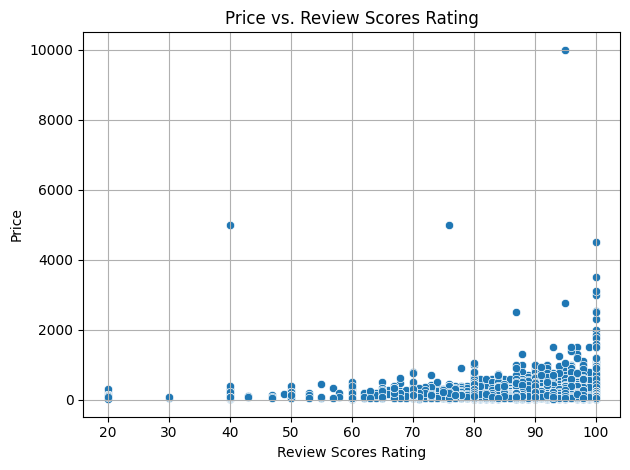

In [16]:
sns.scatterplot(data=data, x='Review Scores Rating', y='Price')
plt.title('Price vs. Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()

# Complex Model Transformation

In [17]:
from sklearn.preprocessing import PolynomialFeatures

X_dummies = pd.get_dummies(data[["Neighbourhood", "Property Type", "Room Type"]], dtype = "int", drop_first = True)
X1 = pd.concat([data["Review Scores Rating"], X_dummies], axis = 1)

# Adds squared terms and interactions between features
expander = PolynomialFeatures(degree = 2, include_bias = False)
Z = expander.fit_transform(X1.iloc[:, :])
names = expander.get_feature_names_out()

X = pd.DataFrame(data = Z, columns = names)
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
results = pd.DataFrame({'variable' : reg.feature_names_in_, 'coefficient' : reg.coef_})

y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
train_rmse = np.sqrt(np.mean((y_train - y_pred_train) ** 2))
test_rmse = np.sqrt(np.mean((y_test - y_pred_test) ** 2))

print("Train RMSE: ", round(train_rmse, 4))
print("R-Squared on Train: ", round(reg.score(X_train, y_train), 4))
print()
print("Test RMSE: ", round(test_rmse, 4))
print("R-Squared on Test: ", round(reg.score(X_test, y_test), 4))
print()
print("Best Simple Model Test RMSE: ", round(results_df.sort_values(by = "Test R^2", ascending = False).iloc[0, 2], 4))
print("Best Simple Model Test R^2: ", round(results_df.sort_values(by = "Test R^2", ascending = False).iloc[0, 4], 4))

Train RMSE:  135.6403
R-Squared on Train:  0.2175

Test RMSE:  112.2396
R-Squared on Test:  0.2465

Best Simple Model Test RMSE:  112.65
Best Simple Model Test R^2:  0.241


**The more complex model performs much better than some of the simpler models, but compared to the best of the "simple" models, the difference in performance ranges from negligible to small depending on the randoms state.**

## Summary

**In the lab, we analyzed how features of Airbnb listings impacted their prices using hedonic pricing models. After we cleaned the dataset and encoded categorical variables such as neighborhood, property type, and room type, we built several simple linear regression models and evaluated them using RMSE and R² on both training and test sets. When we used models that utilized a single variable, it often underfit the data, whereas the combined model with all features performed better overall. We then built a more complex model with interactions and transformations, which showed improved performance over many of the simpler models. What we found however, when comparing it to the best-performing simple model, the improvement was often marginal, and in some cases negligible, depending on the random state used for the train-test split. This suggested that while complexity can help, it does not always lead to an increase predictive power and may introduce sensitivity to data variation. This lab allowed us to learn how overfitting and underfitting can present itself in real data, and how significant careful model selection and validation are for building models that generalize well.**

# Optional Lasso Regularization 

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

X_full = pd.get_dummies(data[['Neighbourhood', 'Property Type', 'Room Type', 'Review Scores Rating']], drop_first=True)
y = data['Price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)


train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)


test_r2 = r2_score(y_test, y_test_pred)

print("Lasso selected", np.sum(lasso.coef_ != 0), "features.")
print("Train RMSE:", round(train_rmse, 2), "Test RMSE:", round(test_rmse, 2))
print("Train R²:", round(train_r2, 3), "Test R²:", round(test_r2, 3))


selected_features = pd.Series(lasso.coef_, index=X_full.columns)
selected_features = selected_features[selected_features != 0].sort_values(ascending=False)

print("\n \nSelected Features by Lasso:")
print(selected_features)

Lasso selected 24 features.
Train RMSE: 135.35 Test RMSE: 129.66
Train R²: 0.185 Test R²: 0.192

Selected Features by Lasso:
Neighbourhood_Manhattan          38.361910
Neighbourhood_Brooklyn           13.533702
Property Type_House              12.765031
Property Type_Loft               12.091796
Review Scores Rating              6.922096
Property Type_Other               3.051210
Property Type_Townhouse           2.186673
Property Type_Condominium         1.964099
Property Type_Bed & Breakfast     1.798224
Neighbourhood_Queens              1.244599
Property Type_Treehouse           1.131372
Property Type_Villa               1.102931
Property Type_Cabin               0.426498
Property Type_Bungalow            0.218611
Property Type_Castle              0.174200
Property Type_Chalet              0.166237
Property Type_Dorm                0.160956
Property Type_Boat               -0.064854
Property Type_Hut                -0.380409
Neighbourhood_Staten Island      -0.683821
Property Type_L